<a href="https://colab.research.google.com/github/gyyang/neurogym/blob/master/examples/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploring NeuroGym tasks

NeuroGym is a comprehensive toolkit that allows training any network model on many established neuroscience tasks using Reinforcement Learning techniques. It includes working memory tasks, value-based decision tasks and context-dependent perceptual categorization tasks.

In this notebook we first show how to install the relevant toolbox. 

We then show how to access the available tasks and their relevant information.

Finally we train an LSTM network on the Random Dots Motion task using the A2C algorithm [Mnih et al. 2016](https://arxiv.org/abs/1602.01783) implemented in the [stable-baselines](https://github.com/hill-a/stable-baselines) toolbox, and plot the results.

You can easily change the code to train a network on any other available task or using a different algorithm (e.g. ACER, PPO2).


### Installation on google colab

In [6]:
%tensorflow_version 1.x
# Install gym
! pip install gym
# Install neurogym
! git clone https://github.com/gyyang/neurogym.git
%cd neurogym/
! pip install -e .
# Install stable-baselines
! pip install --upgrade stable-baselines

UsageError: Line magic function `%tensorflow_version` not found.


### Explore tasks

In [1]:
import warnings
import gym
import neurogym as ngym
from neurogym.utils import info, plotting
warnings.filterwarnings('ignore')
info.all_tasks()

AngleReproduction-v0
AntiReach-v0
Bandit-v0
CVLearning-v0
ChangingEnvironment-v0
ContextDecisionMaking-v0
DawTwoStep-v0
DelayComparison-v0
DelayMatchCategory-v0
DelayMatchSample-v0
DelayMatchSampleDistractor1D-v0
DelayPairedAssociation-v0
Detection-v0
DualDelayMatchSample-v0
EconomicDecisionMaking-v0
GoNogo-v0
HierarchicalReasoning-v0
IntervalDiscrimination-v0
MatchingPenny-v0
MotorTiming-v0
MultiSensoryIntegration-v0
NAltPerceptualDecisionMaking-v0
Nothing-v0
OneTwoThreeGo-v0
PerceptualDecisionMaking-v0
PerceptualDecisionMakingDelayResponse-v0
PostDecisionWager-v0
ProbabilisticReasoning-v0
PulseDecisionMaking-v0
Reaching1D-v0
Reaching1DWithSelfDistraction-v0
ReachingDelayResponse-v0
ReadySetGo-v0
psychopy.RandomDotMotion-v0
psychopy.VisualSearch-v0


### Visualize a single task

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


### PerceptualDecisionMaking
Doc: Two-alternative forced choice task in which the subject has to
    integrate two stimuli to decide which one is higher on average.

    Args:
        stim_scale: Controls the difficulty of the experiment. (def: 1., float)
        sigma: float, input noise level
        dim_ring: int, dimension of ring input and output
    
Reference paper 
[The analysis of visual motion: a comparison of neuronal and psychophysical performance](https://www.jneurosci.org/content/12/12/4745)

Period timing (ms) 
fixation : constant 100
stimulus : constant 2000
decision : constant 100

Reward structure 
abort : -0.1
correct : 1.0
fail : 0.0

Tags: perceptual, two-alternative, supervised.



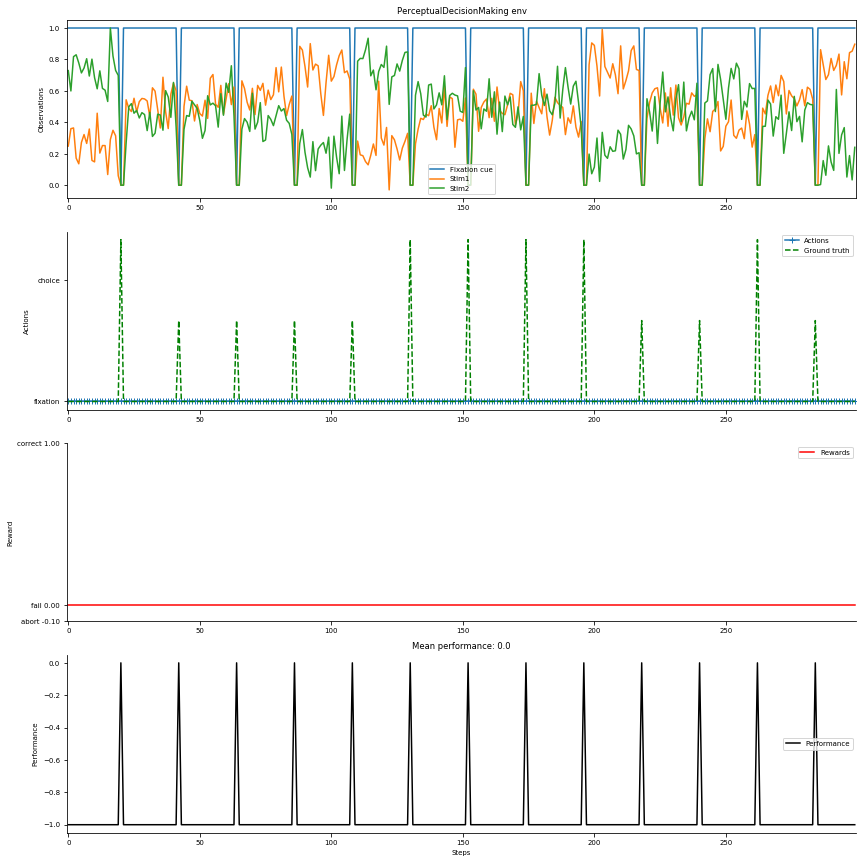

In [2]:
task = 'PerceptualDecisionMaking-v0'
env = gym.make(task);
print(env)
plotting.plot_env(env, num_steps=300, def_act=0, ob_traces=['Fixation cue', 'Stim1', 'Stim2'], fig_kwargs={'figsize': (12, 12)});

### Explore wrappers

In [3]:
info.all_wrappers()

CatchTrials-v0
Combine-v0
Identity-v0
MissTrialReward-v0
Monitor-v0
Noise-v0
PassAction-v0
PassReward-v0
ReactionTime-v0
SideBias-v0
TTLPulse-v0
TransferLearning-v0
TrialHistory-v0


In [4]:
info.info_wrapper('TrialHistory-v0', show_code=True);

### TrialHistory-v0

Logic: Change ground truth probability based on previousoutcome.

Reference paper 

[Response outcomes gate the impact of expectations on perceptual decisions](https://www.biorxiv.org/content/10.1101/433409v3)


#### Source code #### 

class TrialHistory(ngym.TrialWrapper):
    """Change ground truth probability based on previous outcome.

    Args:
        probs: matrix of probabilities of the current choice conditioned
            on the previous for each block. (def: None, np.array,
            num-blocks x num-choices x num-choices)
        block_dur: Number of trials per block. (def: 200 (int))
        blk_ch_prob: If not None, specifies the probability of changing block
            (randomly). (def: None, float)
    """
    metadata = {
        'description': 'Change ground truth probability based on previous' +
        'outcome.',
        'paper_link': 'https://www.biorxiv.org/content/10.1101/433409v3',
        'paper_name': 'Response outcomes gate the impac

### Train a network

In [5]:
import warnings
import numpy as np
from neurogym.wrappers import trial_hist, monitor
from stable_baselines.common.policies import LstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C  # ACER, PPO2
warnings.filterwarnings('default')
# task paremters
task = 'PerceptualDecisionMaking-v0'
timing = {'fixation': ('constant', 300),
          'stimulus': ('constant', 700),
          'decision': ('constant', 300)}
kwargs = {'dt': 100, 'timing': timing, 'stim_scale': 2}
# wrapper parameters
n_ch = 2
p = 0.8
num_blocks = 2
block_1 = np.array([[p, 1-p], [1-p, p]])  # repeating block
block_2 = np.array([[1-p, p], [p, 1-p]])  # alternating block
probs = np.empty((num_blocks, n_ch, n_ch))
probs[0, :, :] = block_1
probs[1, :, :] = block_2

block_dur = 50

# build task
env = gym.make(task, **kwargs)
# Apply the wrapper
env = trial_hist.TrialHistory(env, probs=probs, block_dur=block_dur)
env = monitor.Monitor(env, folder='content/tests/', sv_per=10000, verbose=1, sv_fig=True, num_stps_sv_fig=100)
# the env is now wrapped automatically when passing it to the constructor
env = DummyVecEnv([lambda: env])
model = A2C(LstmPolicy, env, verbose=1, policy_kwargs={'feature_extraction':"mlp"})
model.learn(total_timesteps=500000, log_interval=100000)
env.close()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(2, 2, 2)




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





/home/jeremy/anaconda3/envs/neurogym/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/jeremy/anaconda3/envs/neurogym/lib/python3.7/site-packages/tensorflow_core/python/ops/variable_scope.py:452: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  shape is not None and isinstance(shape, collections_lib.Sequence) and





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.178    |
| fps                | 4        |
| nupdates           | 1        |
| policy_entropy     | 1.1      |
| total_timesteps    | 5        |
| value_loss         | 0.00225  |
---------------------------------
--------------------
Number of steps:  10000.0
Average reward:  0.7333500000000001
--------------------
--------------------
Number of steps:  20000.0
Average reward:  0.83236
--------------------
--------------------
Number of steps:  30000.0
Average reward:  0.8452700000000001
--------------------
--------------------
Number of steps:  40000.0
Average reward:  0.8505
--------------------
---------------------------------
| explained_variance | 0.86     |
| fps                | 21       |
| nupdates     

### Visualize results

(2, 2, 2)


AttributeError: 'DummyVecEnv' object has no attribute 'act_dict'

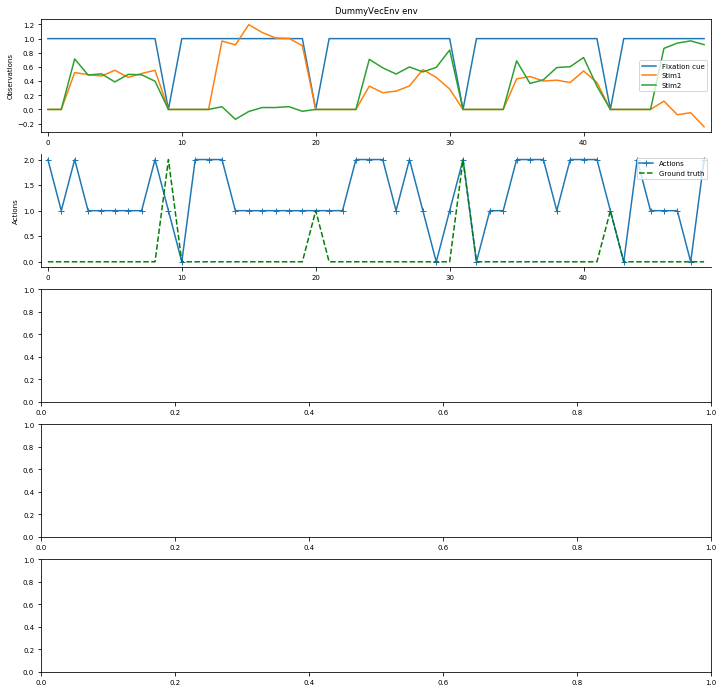

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# Create task
env = gym.make(task, **kwargs)
# Apply the wrapper
env = trial_hist.TrialHistory(env, probs=probs, block_dur=block_dur)
env = DummyVecEnv([lambda: env])
plotting.plot_env(env, num_steps=50, def_act=0, ob_traces=['Fixation cue', 'Stim1', 'Stim2'], fig_kwargs={'figsize': (12, 12)}, model=model);

AttributeError: 'DummyVecEnv' object has no attribute 'act_dict'

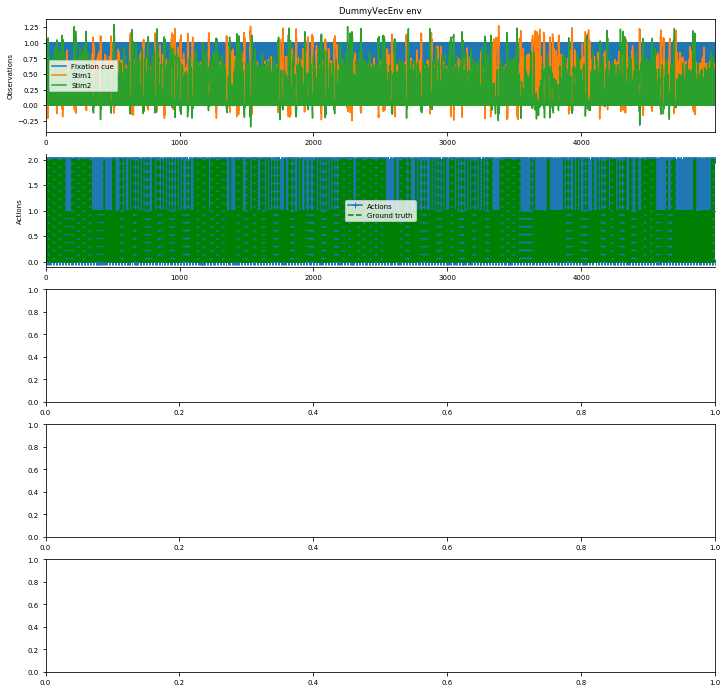

In [13]:
step_by_step_data = plotting.plot_env(env, num_steps=5000, def_act=0, ob_traces=['Fixation cue', 'Stim1', 'Stim2'], fig_kwargs={'figsize': (12, 12)}, model=model);
list(step_by_step_data)

In [14]:
actions_end_of_trial = step_by_step_data['actions_end_of_trial']
actions_end_of_trial = np.array(actions_end_of_trial)
end_of_trial = np.where(actions_end_of_trial != -1)[0]
states = step_by_step_data['states']
states = states[:, int(states.shape[1]/2):]
baseline = 7
resp_window = 3
steps = np.arange(baseline+resp_window) - baseline
end_of_trial = end_of_trial[end_of_trial > baseline]
end_of_trial = end_of_trial[end_of_trial < states.shape[0]-resp_window]
mat_1 = np.zeros((baseline+resp_window, states.shape[1]))
mat_2 = np.zeros((baseline+resp_window, states.shape[1]))
for eot in end_of_trial:
    if actions_end_of_trial[eot] == 1:
        mat_1 += states[eot-baseline:eot+resp_window, :]
    elif actions_end_of_trial[eot] == 2:
        mat_2 += states[eot-baseline:eot+resp_window, :]
    elif actions_end_of_trial[eot] == -1:
        print('INVALID ACTION')

mat_1 -= np.min(mat_1, axis=0)
mat_1 = mat_1/np.mean(mat_1, axis=0)

mat_2 -= np.min(mat_2, axis=0)
mat_2 = mat_2/np.mean(mat_2, axis=0)

diff = np.sum(np.abs(mat_1 - mat_2), axis=0)
arr1inds = diff.argsort()
sorted_mat_1 = mat_1[:, arr1inds[::-1]]
sorted_mat_2 = mat_2[:, arr1inds[::-1]]
rows = 4
cols = 3
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10))
ax = ax.flatten()
for ind_ax in range(rows*cols):
    trace_1 = sorted_mat_1[:, ind_ax]
    trace_1 -= np.min(trace_1)
    trace_1 /= np.max(trace_1)
    ax[ind_ax].plot(steps, trace_1);
    trace_2 = sorted_mat_2[:, ind_ax]
    trace_2 -= np.min(trace_2)
    trace_2 /= np.max(trace_2)
    ax[ind_ax].plot(steps, trace_2);
    ax[ind_ax].plot([0, 0], [0, 1], '--k');


NameError: name 'step_by_step_data' is not defined

In [16]:
cd content/tests/


/home/jeremy/Documents/Postdoc/Projects/Neurogym/neurogym/examples/content/tests


In [17]:
ls

TrialHistory_bhvr_data__10000.npz
TrialHistory_bhvr_data__20000.npz
TrialHistory_bhvr_data__30000.npz
TrialHistory_bhvr_data__40000.npz
TrialHistory_bhvr_data__task_000008.png*
TrialHistory_bhvr_data__task_010009.png
TrialHistory_bhvr_data__task_020009.png
TrialHistory_bhvr_data__task_030009.png
TrialHistory_bhvr_data__task_040009.png


In [19]:
from neurogym.utils import plotting
plotting.plot_rew_across_training('/content/tests/')

No data in:  /content/tests/
